<h1 style="text-align:center;"> Quora Question pairs part-2 </h1>

<h2> 2.1 Tf-Idf and wrod2vec </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

<808580x109679 sparse matrix of type '<class 'numpy.float64'>'
	with 8146555 stored elements in Compressed Sparse Row format>

In [5]:
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [6]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:27:12<00:00, 77.27it/s]


In [7]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:23:01<00:00, 81.15it/s]


In [8]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [9]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [10]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [11]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,...,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,...,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,97.546832,22.972194,-39.558379,18.723413,56.928618,48.307643,8.719268,36.893738,106.899947,226.283077,...,-66.835018,87.592131,4.032431,56.851710,-43.625415,-57.580962,-50.425831,78.591989,105.714355,-33.304158
3,57.586978,-22.017089,-4.599294,-88.939271,-4.732171,-54.209048,74.614947,106.533737,15.520611,39.009709,...,28.362970,41.981222,-11.204987,16.833428,-36.372476,8.927558,-64.553197,95.054246,-34.157576,70.821925
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,...,-4.390959,109.604406,-91.160167,-25.739913,133.123058,-13.508816,-100.115211,208.424382,286.930889,68.027638


In [12]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [17]:
data=pd.read_csv('final_features.csv')

In [21]:
data.head(2)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061


In [23]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [24]:
data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628


In [25]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [26]:
y_true = list(map(int, y_true.values))

In [31]:
#train and test split 
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [32]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307998911664623 Class 1:  0.3692001088335377
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [33]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(30,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1> Machine learning models </h1>

<h2> 3.1 Logistic regression </h2>

For values of alpha =  1e-05 The log loss is: 0.4482982514717718
For values of alpha =  0.0001 The log loss is: 0.4522299601438074
For values of alpha =  0.001 The log loss is: 0.4599038539019206
For values of alpha =  0.01 The log loss is: 0.44432149698713785
For values of alpha =  0.1 The log loss is: 0.4545390627113344
For values of alpha =  1 The log loss is: 0.47829434673692806
For values of alpha =  10 The log loss is: 0.5219985940263491


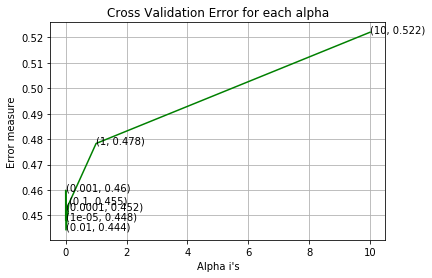

For values of best alpha =  0.01 The train log loss is: 0.4462971637320382
For values of best alpha =  0.01 The test log loss is: 0.44432149698713785
Total number of data points : 121287


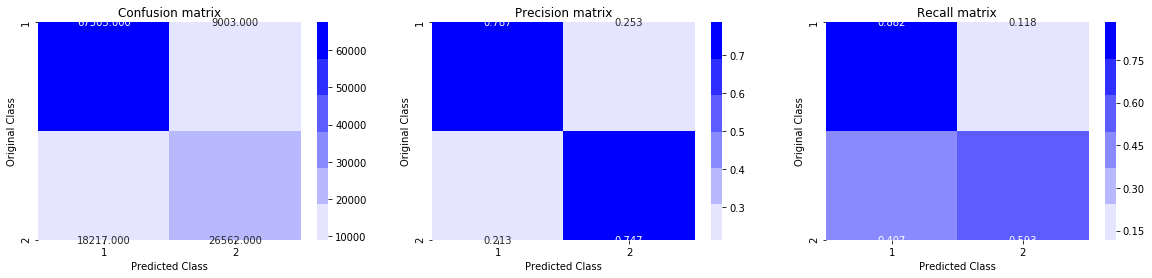

In [34]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)